**Note:** If running at DTU HPC, remember to set `n_jobs` to something else than `-1`!

In [1]:
from google.colab import drive, userdata
import os
drive.mount('/content/drive')
drive_dir = '/content/drive/My Drive/'
data_dir = os.path.join(drive_dir, 'Detection-datasets')
cache_dir = os.path.join(drive_dir, 'model_cache')

Mounted at /content/drive


In [2]:
random_state = 42   # For statification. I seed the generator to ensure the splits are paired.

In [3]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.3 MB/s eta 0:00:00


```
import optuna

def objective(trial):
    x = trial.suggest_float('x', -10, 10)
    return (x - 2) ** 2

study = optuna.create_study()
study.optimize(objective, n_trials=100)

study.best_params  # E.g. {'x': 2.002108042}
```
Source: https://optuna.org/

In [4]:
## Small test: Does the random seeding work when the X's differ? (Yes it does)
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np

n_obs = 100
n_feats = 5
X_1 = np.arange(n_obs*n_feats).reshape(n_obs, n_feats)
X_2 = np.arange(n_obs*n_feats, 2*n_obs*n_feats).reshape(n_obs, n_feats)
y = np.hstack((np.zeros(n_obs//2), np.ones(n_obs//2)))
groups = np.arange(n_obs)

fold_1 = StratifiedGroupKFold(shuffle=True, random_state=42)
fold_2 = StratifiedGroupKFold(shuffle=True, random_state=42)

for (train_1, test_1), (train_2, test_2) in zip(fold_1.split(X_1, y, groups), fold_2.split(X_2, y, groups)):
  assert (train_1==train_2).all()
  assert (test_1==test_2).all()

In [5]:
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedGroupKFold, GroupShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from scipy.stats import beta
from typing import Dict, List, Tuple
from time import time
import seaborn as sns
from tqdm.notebook import tqdm
from functools import partial
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)


linear_svm_params = {
  'SVC__C': [0.001, 0.01, 0.1, 1.0, 10.0],
  'SVC__kernel': ['linear'],
  'SVC_gamma': [1.]
}
rbf_svm_params = {
  'SVC__C': [0.001, 0.01, 0.1, 1.0, 10.0],
  'SVC__kernel': ['rbf'],
  'SVC_gamma': [1e-4, 1e+3],
}
debug_svm_params = {
    'HeadSelector__layer_ix': [8,9],
    'HeadSelector__head_ix': [8,9],
    'SVC__C': [0.1],
    'SVC__kernel': ['linear'],
    'SVC_gamma': [1e-4, 1e+3],
}


def make_pipeline(HeadSelector__layer_ix, HeadSelector__head_ix, SVC__C, SVC__kernel, SVC__gamma):
  return Pipeline([
    ('HeadSelector', HeadSelector(layer_ix=HeadSelector__layer_ix, head_ix=HeadSelector__head_ix)),   # Head selector's layer_ix, and head_ix are set in CV.
    ('StandardScaler', StandardScaler()),
    ('SVC', SVC(C=SVC__C, gamma=SVC__gamma, kernel=SVC__kernel)),
  ])


def objective(trial, X_train, X_val, y_train, y_val, param_grid):
  HeadSelector__layer_ix = trial.suggest_int(
    'HeadSelector__layer_ix',
    low=min(param_grid['HeadSelector__layer_ix']),
    high=max(param_grid['HeadSelector__layer_ix'])-1,
  )
  HeadSelector__head_ix = trial.suggest_int(
    'HeadSelector__head_ix',
    low=min(param_grid['HeadSelector__head_ix']),
    high=max(param_grid['HeadSelector__head_ix'])-1,
  )
  SVC__C = trial.suggest_float(
    'SVC__C',
    low=min(param_grid['SVC__C']),
    high=max(param_grid['SVC__C']),
    log=True,
  )
  SVC__kernel = trial.suggest_categorical(
      'SVC__kernel',
      param_grid['SVC__kernel']
  )
  SVC__gamma = trial.suggest_float(
      'SVC__gamma',
      low=min(param_grid['SVC_gamma']),
      high=max(param_grid['SVC_gamma']) if 'rbf' in param_grid['SVC__kernel'] else min(param_grid['SVC_gamma']),
      log=True
  )
  probe_pipeline = make_pipeline(HeadSelector__layer_ix, HeadSelector__head_ix, SVC__C, SVC__kernel, SVC__gamma)
  probe_pipeline.fit(X_train, y_train)
  acc = np.mean(y_val == probe_pipeline.predict(X_val))
  assert isinstance(acc, float) or (len(acc) == 1)
  return -acc   # Optuna minimizes


class HeadSelector(BaseEstimator, TransformerMixin):
  def __init__(self, layer_ix=None, head_ix=None):
    self.layer_ix = layer_ix
    self.head_ix = head_ix

  def fit(self, X: np.array, y:None):
    return self

  def transform(self, features: np.ndarray) -> np.ndarray:
    # Features has shape: [num_layers, num_samples, num_heads, head_dim]
    out = features[:,self.layer_ix,self.head_ix,:]
    assert out.ndim == 2
    return out   # [num_samples, head_dim]


def make_joint_plot(activations, labels, layer_ix, head_ix, title):
  head_selector = HeadSelector(layer_ix, head_ix)
  X = head_selector.transform(activations)
  y = labels

  # Greedily find the two directions with highest predictability.
  first_direction = SVC(kernel='linear')
  second_direction = SVC(kernel='linear')
  first_direction.fit(X,y)
  w1 = first_direction.coef_.T
  proj_1 = X @ w1
  X_minus_proj_1 = X - proj_1/(w1.T.dot(w1))*w1.reshape(1,-1)
  assert np.isclose(X_minus_proj_1@w1,0.).all()    # Check that it is orthogonal.
  second_direction.fit(X_minus_proj_1,y)
  w2 = second_direction.coef_.T
  proj_2 = X @ w2

  d = pd.DataFrame({
      "SVM direction 1": proj_1.ravel(),
      "SVM direction 2": proj_2.ravel(),
      "label": y.ravel().astype(bool)
  })
  sns.set_theme()    # https://seaborn.pydata.org/tutorial/introduction.html and https://seaborn.pydata.org/generated/seaborn.kdeplot.html
  #sns.kdeplot(data=d, x="P1", y="P2", hue="label", fill=True)#, levels=5, thresh=.2)
  g = sns.jointplot(data=d, x="SVM direction 1", y="SVM direction 2", hue="label", marker='.')
  g.plot_joint(sns.kdeplot, zorder=0, levels=5)

  g.fig.suptitle(title)
  g.ax_joint.collections[0].set_alpha(0)
  g.fig.tight_layout()
  g.fig.subplots_adjust(top=0.95) # Reduce plot to make room


def CV_experiment(activations, labels, param_grid, title, n_trials, ood_test_sets:List[Tuple[np.ndarray, np.ndarray]]=[], groups=None, ci_alpha = 0.05, n_jobs=-1):
  """
    Runs 2-layer CV on an SVM probe with a set kernel.
    The CV setup is like this:
    - For the outer loop, we use (repeated) hold-out - i.e. split in dev and test set.
    - For the inner loop, we use K-fold CV to pick the best scoring parameters. Note that the best classifier is then retrained by Scikit-Learn to predict on the test set.
    The CV is grouped when groups are given. It defaults to non-grouped CV.
    Using the test set, we finally compute the Jeffrey Intervals.

    Args:
      - activations: The activations in this format [num_samples, num_layers, num_heads, head_dim]
      - labels: The labels for the statements corresponding to the activations in shape [num_samples,]
      - param_grid: Parameter grid for the probes. Adheres to Scikit-Learns documentation for GridSearchCV. Be sure to include the layers and heads in this one!
          Example:
            param_grid = {
              'HeadSelector__layer_ix': list(range(0,activations.shape[1])),     # If not specified, it will automatically insert them.
              'HeadSelector__head_ix': list(range(0,activations.shape[2])),
              'SVC__C': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0],
              'SVC__kernel': ['rbf'],
            }

      - ood_test_sets: Out-of-distribution test sets which we will also evaluate on by using the probe trained on the dev_set (i.e. it is NOT retrained).
          Has format: [(X,y),(X,y),(X,y),...] where each (X,y) is a separate test set.
      - groups: For how to group the data in the CV to ensure no information leakage.
      - ci_alpha: The alpha value used in computing the 1-alpha (central) confidence intervals.
      - n_inner_folds: Number of inner CV folds
      - n_jobs: The number of parallel jobs to run. Defaults to -1 meaning ALL available workers (set it to less if running at HPC!!!)
  """
  n_outer_holdout_repeats = 1  # Should not be changed without modifying the CI computation.

  if not 'HeadSelector__layer_ix' in param_grid.keys():
    param_grid['HeadSelector__layer_ix'] = list(range(0,activations.shape[1]))
  if not 'HeadSelector__head_ix' in param_grid.keys():
    param_grid['HeadSelector__head_ix'] = list(range(0,activations.shape[2]))

  if groups is None:
    groups = np.arange(len(labels))   # I.e. each instance becomes a group = no grouping
  elif not isinstance(groups, np.ndarray):
    groups = groups.to_numpy()
  if not isinstance(labels, np.ndarray):
    labels = labels.to_numpy()

  inner_cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=random_state)  # Random state to ensure the observations are paired between the runs.
  outer_cv = StratifiedGroupKFold(n_splits=2, shuffle=True, random_state=random_state)    # Implement holdout by breaking after this

  probe_pipeline = Pipeline([
      ('HeadSelector', HeadSelector()),   # Head selector's layer_ix, and head_ix are set in CV.
      ('StandardScaler', StandardScaler()),
      ('SVC', SVC())
  ])

  # Cross validate. Outer loop: Holdout, Inner loop: k-fold
  start_time = time()
  correct_guesses = 0
  for dev_idx, test_idx in tqdm(outer_cv.split(activations, labels, groups=groups), desc="Outer CV", total=n_outer_holdout_repeats, leave=True):
    # Assert that the dev set and test set partition the entire dataset correctly based on groups
    assert len(set(groups[dev_idx]).intersection(set(groups[test_idx]))) == 0  # Disjoint
    assert (len(dev_idx) + len(test_idx)) == len(labels)  # Covers entire dataset

    # Inner CV: Hold-out
    for train_idx, val_idx in tqdm(inner_cv.split(activations[dev_idx,:,:,:], labels[dev_idx], groups=groups[dev_idx]), desc="Inner CV", total=1, leave=False):
      # Select data
      X_train, y_train = activations[dev_idx,...][train_idx,...], labels[dev_idx][train_idx]
      X_val, y_val = activations[dev_idx,...][val_idx,...], labels[dev_idx][val_idx]

      # Optimize
      obj_partial = partial(objective, param_grid=param_grid, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)
      study = optuna.create_study()
      study.optimize(obj_partial, n_trials=n_trials, show_progress_bar=True, n_jobs=-1)
      best_params = study.best_params
      break

    # Retrain best model on dev set.
    probe = make_pipeline(**best_params).fit(activations[dev_idx,...], labels[dev_idx])
    layer_ix, head_ix = best_params['HeadSelector__layer_ix'], best_params['HeadSelector__head_ix']

    # Predict on the test set
    pred = probe.predict(activations[test_idx,:,:,:])   # Note: the best model is refitted by Scikit-Learn.
    is_correct = (pred == labels[test_idx])
    correct_guesses += np.sum(is_correct)

    break   # Implement holdout by breaking

  make_joint_plot(activations, labels, layer_ix, head_ix, title)

  # Compute Jeffrey CI's:
  N = len(test_idx)
  m = correct_guesses
  a = m+0.5
  b = N-m+0.5
  acc_est = m/N
  CI = np.array([beta.ppf(q=q, a=a, b=b) for q in [ci_alpha/2., 1-ci_alpha/2.]])
  CI = [f"{c*100:.0f}%" for c in CI]
  return_dict = {
      "test_acc": acc_est,
      "test_acc_CI": CI,
      "test_acc_support": N,
      "test_n_correct_predictions": m,
      "test_is_correct": is_correct
  }
  end_time = time()
  return_dict['CV_time'] = end_time-start_time   # In seconds

  # Evaluate the trained best probe on the alternative test sets:
  if len(ood_test_sets) > 0:
    for i, (X, y) in enumerate(ood_test_sets):
      pred = probe.predict(X)
      is_correct = (pred == y)
      m = np.sum(is_correct)
      N = len(y)
      a = m+0.5
      b = N-m+0.5
      acc_est = m/N
      CI = np.array([beta.ppf(q=q, a=a, b=b) for q in [ci_alpha/2., 1-ci_alpha/2.]])
      CI = [f"{c*100:.0f}%" for c in CI]
      return_dict[f'ood_test_{i}_acc'] = acc_est
      return_dict[f'ood_test_{i}_acc_CI'] = CI
      return_dict[f'ood_test_{i}_acc_support'] = N
      return_dict[f'ood_test_{i}_n_correct_predictions'] = m
      return_dict[f'ood_test_{i}_is_correct'] = is_correct

  return return_dict, study

In [6]:
import os
datasets = ["TruthfulQA", "Politicians_prepared_old"]
models = ["facebook/opt-125m", "facebook/opt-350m", "facebook/opt-2.7b", "meta-llama/Llama-2-7b-chat-hf", "microsoft/Phi-3-mini-4k-instruct", "meta-llama/Meta-Llama-3-8B"]


truthful_qa_ = "TruthfulQA"
datasets_ = list(filter(lambda x: 'truthfulqa' not in x.lower(), datasets))
datasets

['TruthfulQA', 'Politicians_prepared_old']

## Compute the baseline performance


In [7]:
import pandas as pd
for ds_name in datasets:
  if ds_name == "Politicians_prepared_old":
    pd.read_csv(os.path.join(data_dir, f"{ds_name}.csv"))['isTrue'].to_numpy()
  else:
    y_true = pd.read_csv(os.path.join(data_dir, f"{ds_name}_prepared.csv"))['isTrue'].to_numpy()   # Is a binary label...
  baseline = np.mean(y_true)
  if baseline < .5:
    baseline = 1.-baseline
  print(f"Baseline accuracy for {ds_name} (by betting on the most common binary label): {baseline}")

Baseline accuracy for TruthfulQA (by betting on the most common binary label): 0.5606623859411963
Baseline accuracy for Politicians_prepared_old (by betting on the most common binary label): 0.5606623859411963


## Train on TruthfulQA

### Linear SVM

TruthfulQA Politicians_prepared_old
opt-125m                [70%, 74%]               [46%, 50%]
opt-350m                [66%, 71%]               [47%, 51%]
opt-2.7b                [69%, 73%]               [48%, 52%]
Llama-2-7b-chat-hf      [65%, 69%]               [45%, 49%]
Phi-3-mini-4k-instruct  [71%, 75%]               [46%, 50%]
Meta-Llama-3-8B         [77%, 80%]               [44%, 48%]

Time for Meta-Llama-3-8B: 104.46s
\begin{tabular}{lll}
\toprule
 & TruthfulQA & Politicians_prepared_old \\
\midrule
opt-125m & ['70%', '74%'] & ['46%', '50%'] \\
opt-350m & ['66%', '71%'] & ['47%', '51%'] \\
opt-2.7b & ['69%', '73%'] & ['48%', '52%'] \\
Llama-2-7b-chat-hf & ['65%', '69%'] & ['45%', '49%'] \\
Phi-3-mini-4k-instruct & ['71%', '75%'] & ['46%', '50%'] \\
Meta-Llama-3-8B & ['77%', '80%'] & ['44%', '48%'] \\
\bottomrule
\end{tabular}



TruthfulQA Politicians_prepared_old
opt-125m                [70%, 74%]               [46%, 50%]
opt-350m                [66%, 71%]               [47%, 51%]
opt-2.7b                [69%, 73%]               [48%, 52%]
Llama-2-7b-chat-hf      [65%, 69%]               [45%, 49%]
Phi-3-mini-4k-instruct  [71%, 75%]               [46%, 50%]
Meta-Llama-3-8B         [77%, 80%]               [44%, 48%]

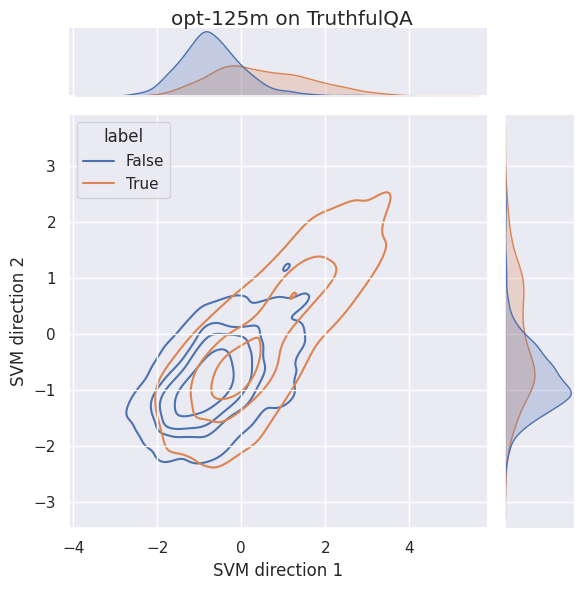

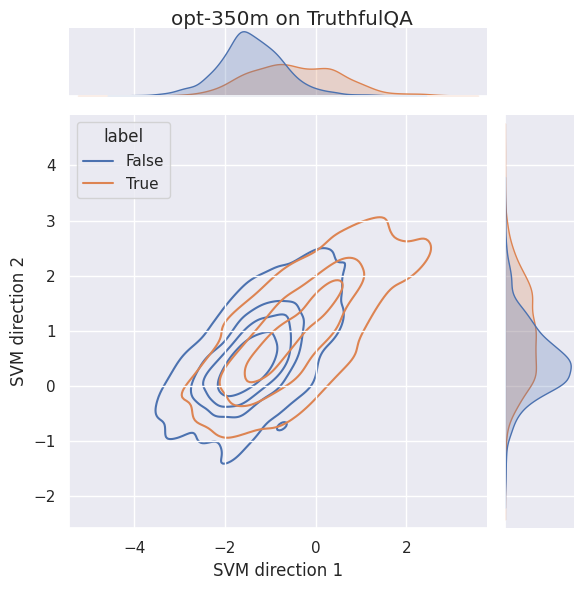

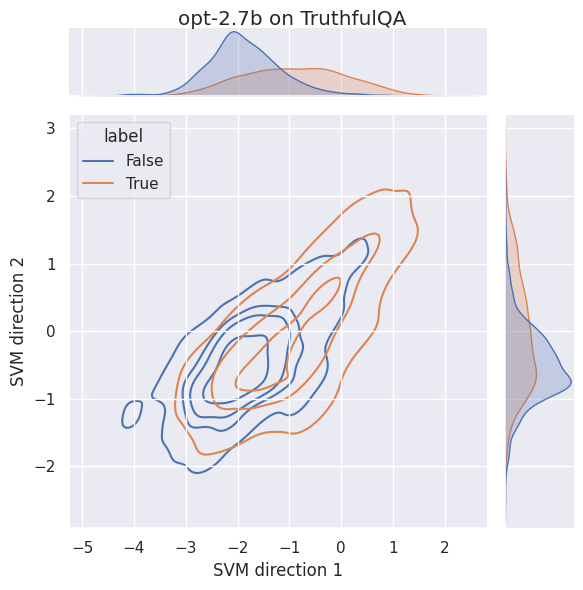

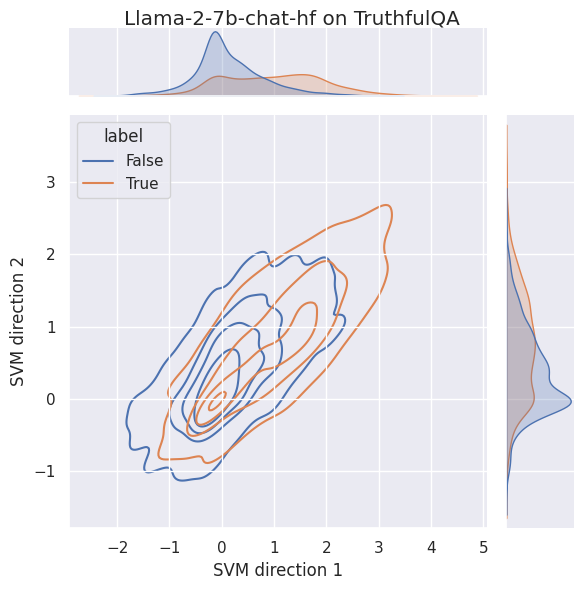

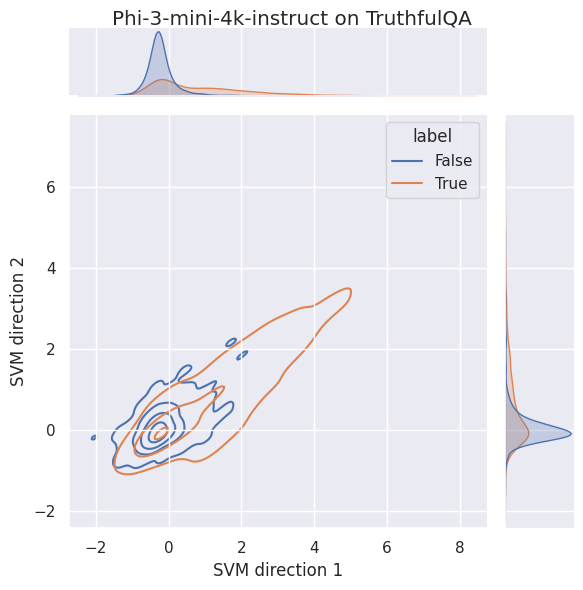

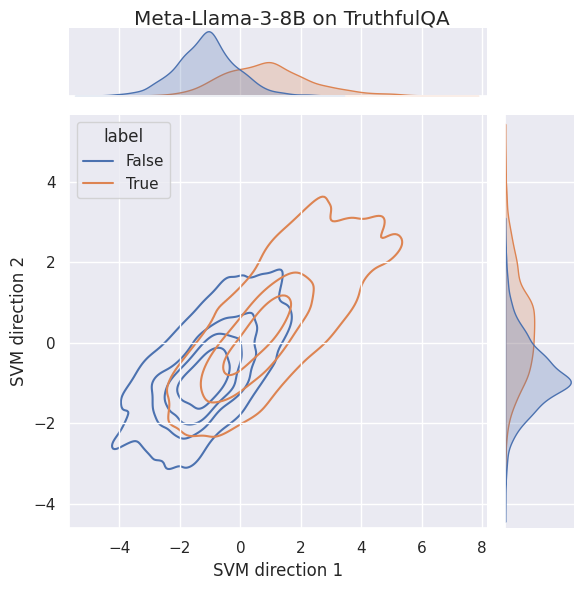

In [8]:
import pandas as pd
from IPython.display import display, clear_output

#truthful_qa_df = pd.read_csv(os.path.join(data_dir, f"{truthful_qa_}_prepared.csv"))

performance_df = pd.DataFrame(columns=['TruthfulQA'] + datasets_, index=[model.split('/')[-1] for model in models])
model_results_linear_svm_with_ood = {}

for i, model in tqdm(enumerate(models), total=len(models), desc='Models', leave=False):
  model_name_str = model.split('/')[-1]
  truthful_qa = np.load(os.path.join(data_dir, f"Activations_{truthful_qa_}_{model_name_str}.npz"))
  truthful_qa_activations = truthful_qa['activations']
  truthful_qa_labels = truthful_qa['labels']
  truthful_qa_groups = truthful_qa['group']
  ood_test_sets = [
      (
          np.load(os.path.join(data_dir, f"Activations_{ds_name}_{model_name_str}.npz"))['activations'],
          np.load(os.path.join(data_dir, f"Activations_{ds_name}_{model_name_str}.npz"))['labels'] #pd.read_csv(os.path.join(data_dir, f"{ds_name}_prepared.csv"))['isTrue']
      )  # (X,y)
      for ds_name in datasets_
  ]
  results, study = CV_experiment(
      activations=truthful_qa_activations,
      labels=truthful_qa_labels,
      groups=truthful_qa_groups,
      param_grid=linear_svm_params,
      ood_test_sets=ood_test_sets,
      title=f"{model_name_str} on TruthfulQA",
      n_trials=1000,
  )
  model_results_linear_svm_with_ood[model_name_str] = results
  performance_df.loc[model_name_str] = [results['test_acc_CI']] + [results[f'ood_test_{i}_acc_CI'] for i in range(len(datasets_))]
  clear_output(wait=True)
  display(performance_df)
  print(f"Time for {model_name_str}: {results['CV_time']:.2f}s")

  #fig = optuna.visualization.plot_parallel_coordinate(study, params=['HeadSelector__layer_ix', 'HeadSelector__head_ix', 'SVC__C'])
  #display(fig)

print(performance_df.to_latex())
performance_df

### RBF SVM

TruthfulQA Politicians_prepared_old
opt-125m                [75%, 79%]               [46%, 50%]
opt-350m                [74%, 78%]               [38%, 42%]
opt-2.7b                [74%, 78%]               [48%, 52%]
Llama-2-7b-chat-hf      [74%, 78%]               [49%, 52%]
Phi-3-mini-4k-instruct  [75%, 79%]               [47%, 51%]
Meta-Llama-3-8B         [82%, 85%]               [49%, 53%]

Time for Meta-Llama-3-8B: 94.49s
\begin{tabular}{lll}
\toprule
 & TruthfulQA & Politicians_prepared_old \\
\midrule
opt-125m & ['75%', '79%'] & ['46%', '50%'] \\
opt-350m & ['74%', '78%'] & ['38%', '42%'] \\
opt-2.7b & ['74%', '78%'] & ['48%', '52%'] \\
Llama-2-7b-chat-hf & ['74%', '78%'] & ['49%', '52%'] \\
Phi-3-mini-4k-instruct & ['75%', '79%'] & ['47%', '51%'] \\
Meta-Llama-3-8B & ['82%', '85%'] & ['49%', '53%'] \\
\bottomrule
\end{tabular}



TruthfulQA Politicians_prepared_old
opt-125m                [75%, 79%]               [46%, 50%]
opt-350m                [74%, 78%]               [38%, 42%]
opt-2.7b                [74%, 78%]               [48%, 52%]
Llama-2-7b-chat-hf      [74%, 78%]               [49%, 52%]
Phi-3-mini-4k-instruct  [75%, 79%]               [47%, 51%]
Meta-Llama-3-8B         [82%, 85%]               [49%, 53%]

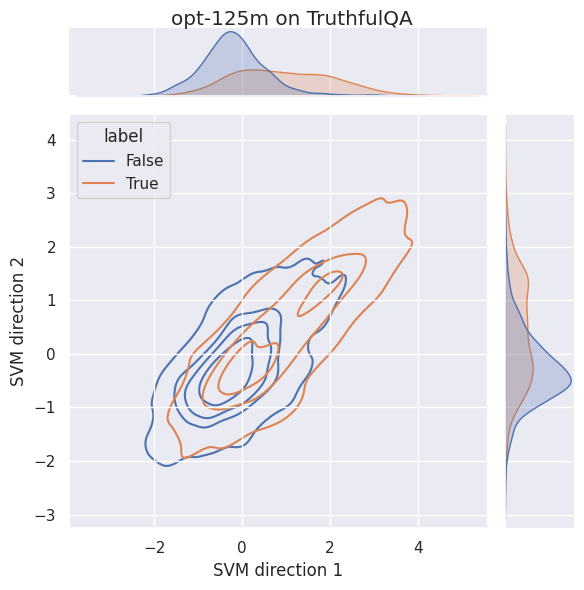

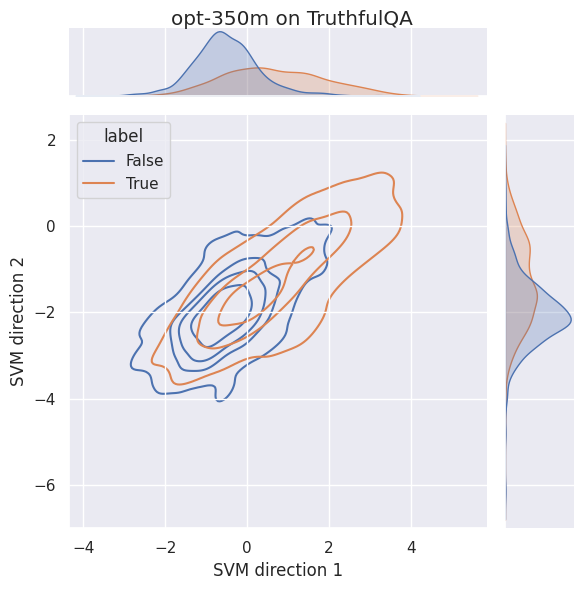

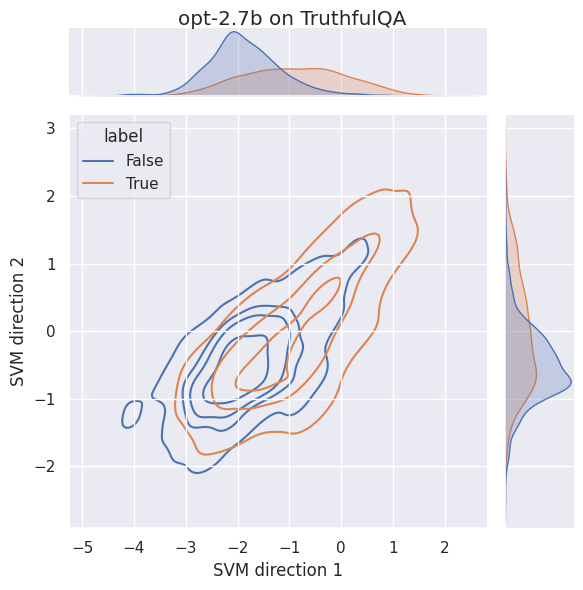

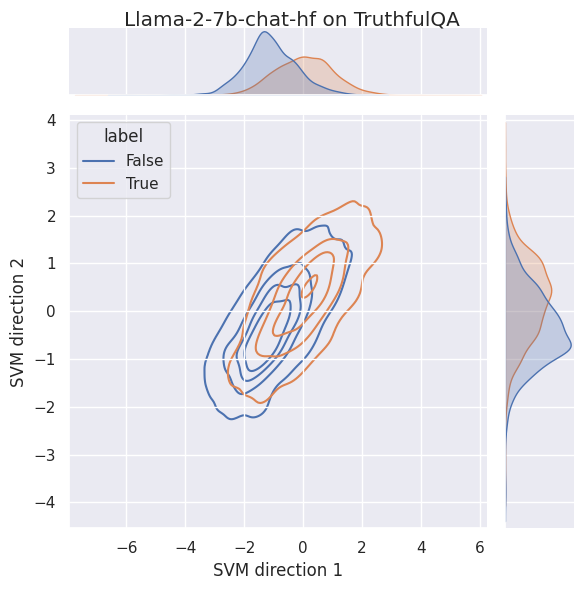

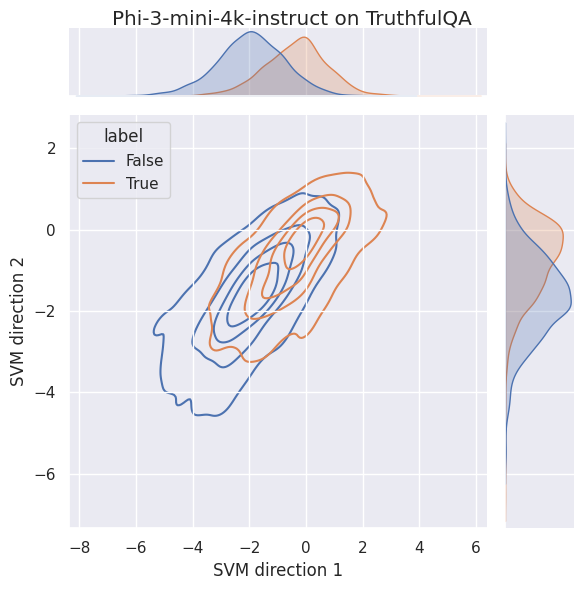

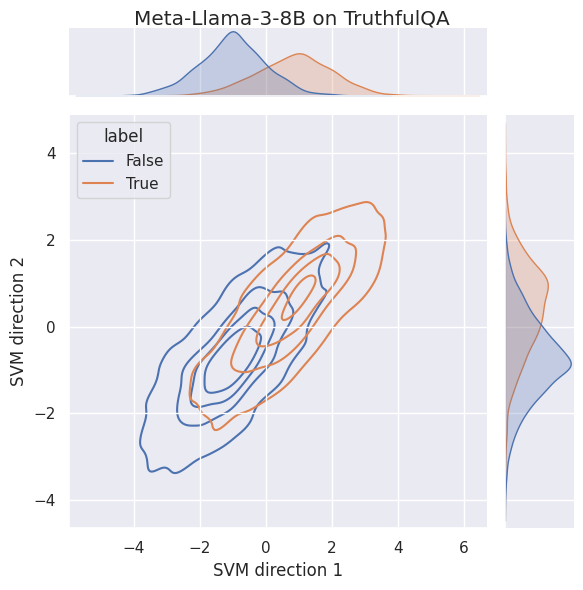

In [9]:
import pandas as pd
from IPython.display import display, clear_output

#truthful_qa_df = pd.read_csv(os.path.join(data_dir, f"{truthful_qa_}_prepared.csv"))
#truthful_qa_labels = truthful_qa_df['isTrue']
#truthful_qa_groups = truthful_qa_df['Group']

performance_df = pd.DataFrame(columns=['TruthfulQA'] + datasets_, index=[model.split('/')[-1] for model in models])
model_results_nonlinear_svm_with_ood = {}

for i, model in tqdm(enumerate(models), total=len(models), desc='Models', leave=False):
  model_name_str = model.split('/')[-1]
  #truthful_qa_activations = np.load(os.path.join(data_dir, f"Activations_{truthful_qa_}_{model_name_str}.npz"))['activations']
  truthful_qa = np.load(os.path.join(data_dir, f"Activations_{truthful_qa_}_{model_name_str}.npz"))
  truthful_qa_activations = truthful_qa['activations']
  truthful_qa_labels = truthful_qa['labels']
  truthful_qa_groups = truthful_qa['group']
  ood_test_sets = [
      (
          np.load(os.path.join(data_dir, f"Activations_{ds_name}_{model_name_str}.npz"))['activations'],
          np.load(os.path.join(data_dir, f"Activations_{ds_name}_{model_name_str}.npz"))['labels'] #pd.read_csv(os.path.join(data_dir, f"{ds_name}_prepared.csv"))['isTrue']
      )  # (X,y)
      for ds_name in datasets_
  ]
  results, study = CV_experiment(
      activations=truthful_qa_activations,
      labels=truthful_qa_labels,
      groups=truthful_qa_groups,
      param_grid=rbf_svm_params,
      ood_test_sets=ood_test_sets,
      n_trials=1000,
      title=f"{model_name_str} on TruthfulQA",
  )
  model_results_nonlinear_svm_with_ood[model_name_str] = results
  performance_df.loc[model_name_str] = [results['test_acc_CI']] + [results[f'ood_test_{i}_acc_CI'] for i in range(len(datasets_))]
  clear_output(wait=True)
  display(performance_df)
  print(f"Time for {model_name_str}: {results['CV_time']:.2f}s")

  #fig = optuna.visualization.plot_parallel_coordinate(study, params=['HeadSelector__layer_ix', 'HeadSelector__head_ix', 'SVC__C'])
  #display(fig)

print(performance_df.to_latex())
performance_df

## Train on respective datasets

### Linear SVM

TruthfulQA Politicians_prepared_old
opt-125m                [72%, 76%]               [72%, 76%]
opt-350m                [68%, 72%]               [69%, 74%]
opt-2.7b                [68%, 73%]               [66%, 71%]
Llama-2-7b-chat-hf      [69%, 73%]               [74%, 79%]
Phi-3-mini-4k-instruct  [71%, 75%]               [73%, 78%]
Meta-Llama-3-8B         [77%, 80%]               [77%, 82%]

Time for Meta-Llama-3-8B: 85.03s
\begin{tabular}{lll}
\toprule
 & TruthfulQA & Politicians_prepared_old \\
\midrule
opt-125m & ['72%', '76%'] & ['72%', '76%'] \\
opt-350m & ['68%', '72%'] & ['69%', '74%'] \\
opt-2.7b & ['68%', '73%'] & ['66%', '71%'] \\
Llama-2-7b-chat-hf & ['69%', '73%'] & ['74%', '79%'] \\
Phi-3-mini-4k-instruct & ['71%', '75%'] & ['73%', '78%'] \\
Meta-Llama-3-8B & ['77%', '80%'] & ['77%', '82%'] \\
\bottomrule
\end{tabular}



TruthfulQA Politicians_prepared_old
opt-125m                [72%, 76%]               [72%, 76%]
opt-350m                [68%, 72%]               [69%, 74%]
opt-2.7b                [68%, 73%]               [66%, 71%]
Llama-2-7b-chat-hf      [69%, 73%]               [74%, 79%]
Phi-3-mini-4k-instruct  [71%, 75%]               [73%, 78%]
Meta-Llama-3-8B         [77%, 80%]               [77%, 82%]

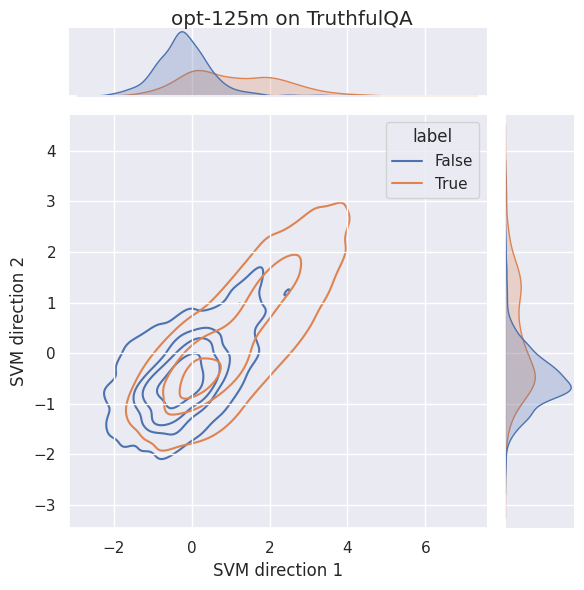

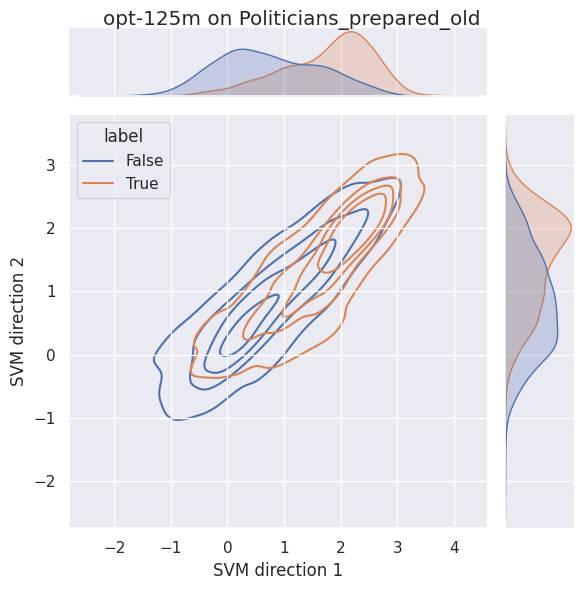

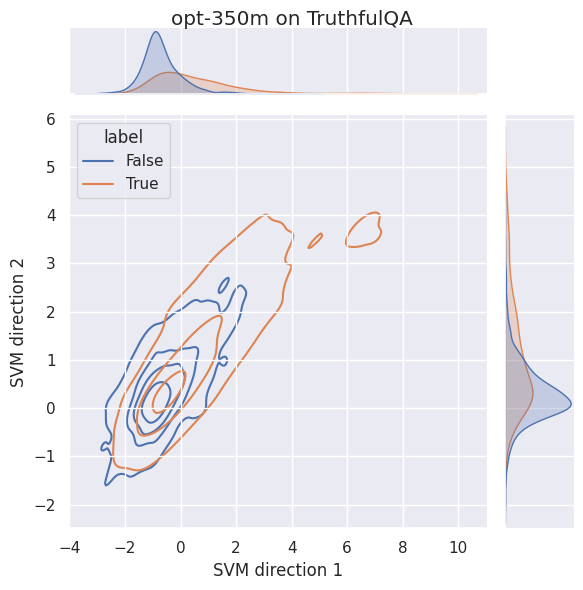

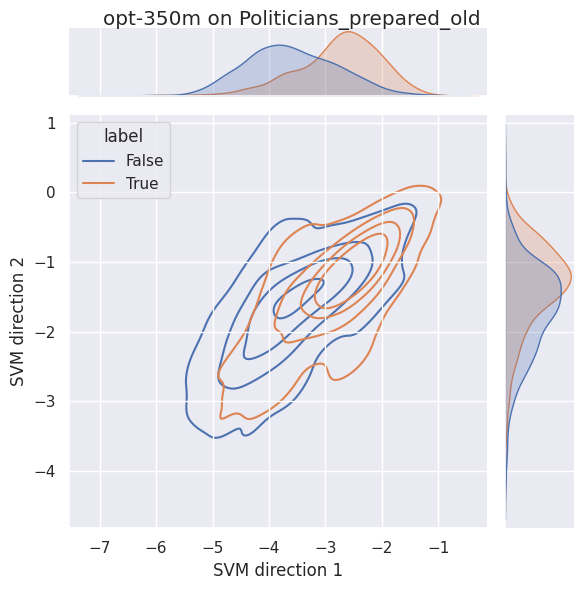

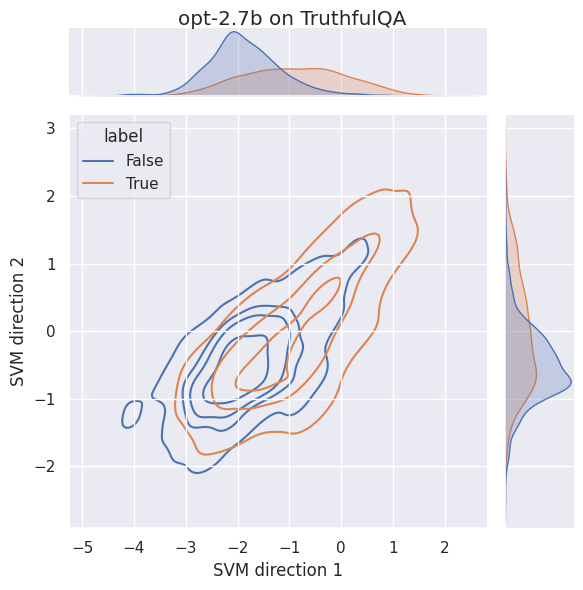

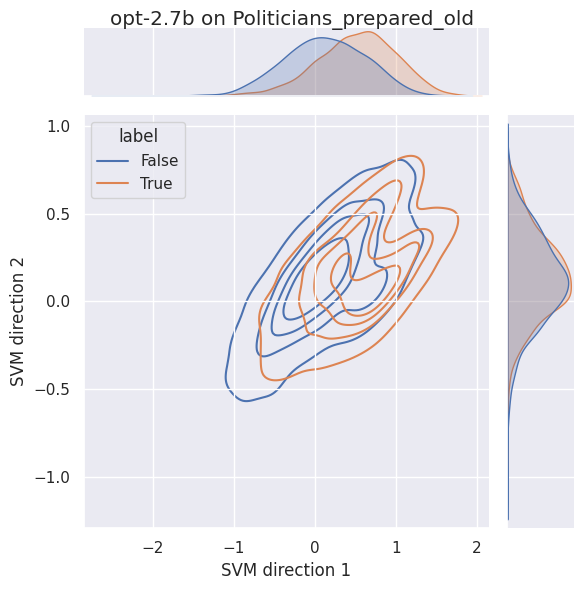

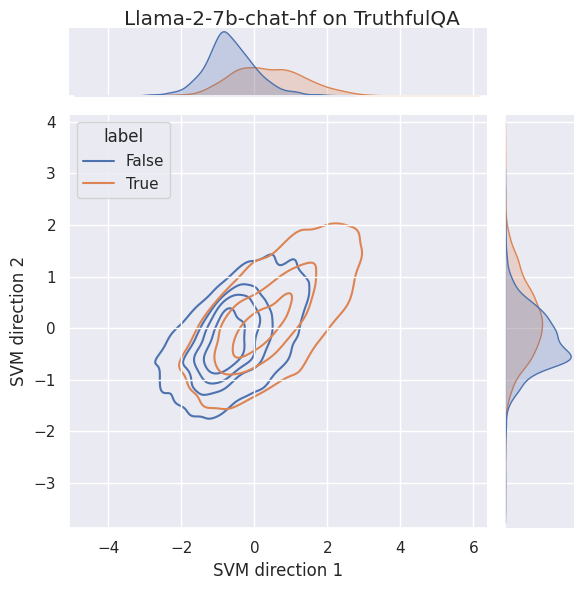

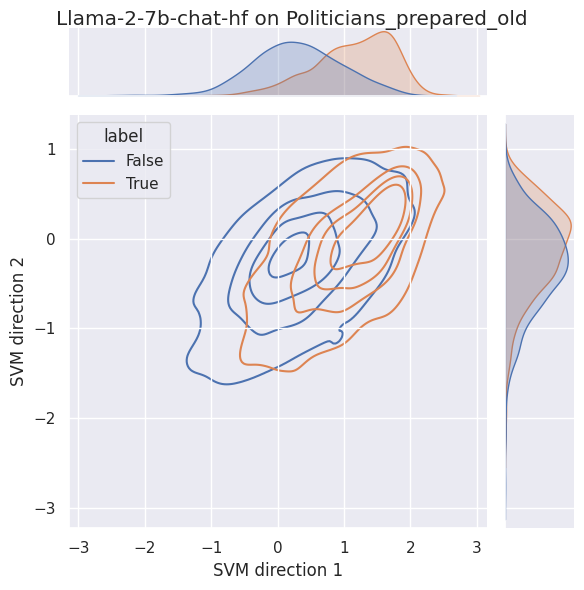

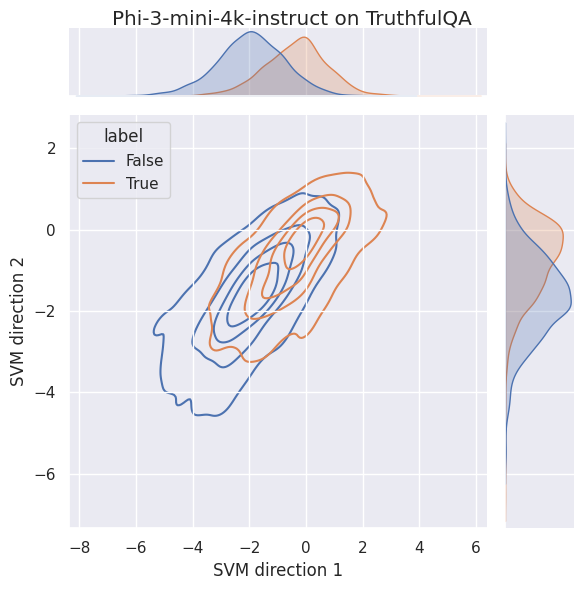

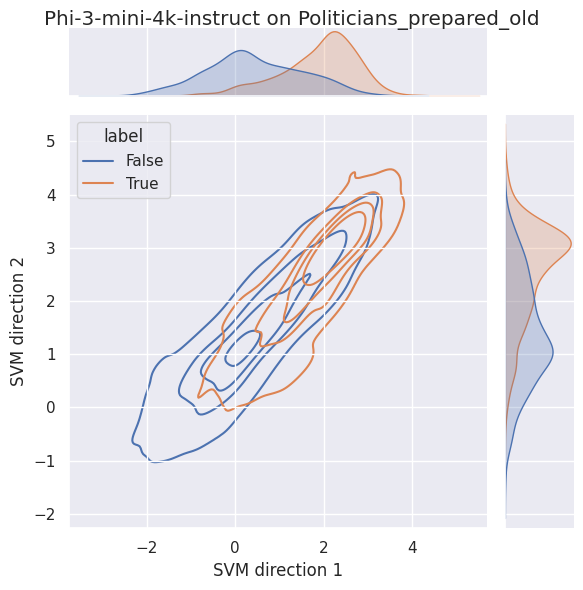

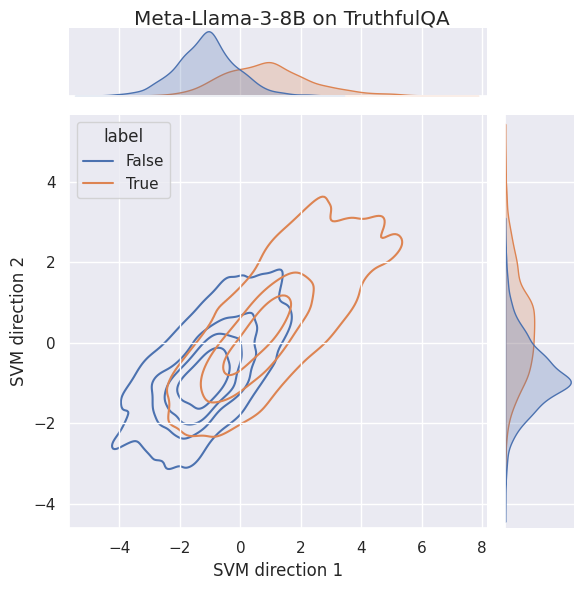

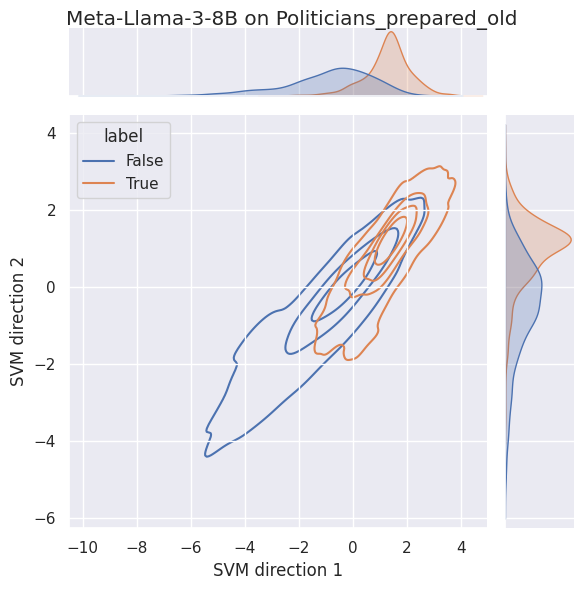

In [10]:
import pandas as pd
from IPython.display import display, clear_output

performance_df = pd.DataFrame(columns=datasets, index=[model.split('/')[-1] for model in models])
model_results_linear_svm_without_ood = {}

for i, model in tqdm(enumerate(models), total=len(models), desc='Models', leave=False):
  row = []
  model_name_str = model.split('/')[-1]
  model_results_linear_svm_without_ood[model_name_str] = {}
  for ds_name in tqdm(datasets, desc='Datasets', leave=False):
    ds_acts = np.load(os.path.join(data_dir, f"Activations_{ds_name}_{model_name_str}.npz"), allow_pickle=True)
    activations = ds_acts['activations']
    labels = ds_acts['labels']
    groups = ds_acts['group']
    results, study = CV_experiment(
        activations=activations,
        labels=labels,
        groups=groups,
        param_grid=linear_svm_params,
        n_trials=1000,
        title=f"{model_name_str} on {ds_name}",
    )
    model_results_linear_svm_without_ood[model_name_str][ds_name] = results
    row.append(results['test_acc_CI'])


  performance_df.loc[model_name_str] = row
  clear_output(wait=True)
  display(performance_df)
  print(f"Time for {model_name_str}: {results['CV_time']:.2f}s")

print(performance_df.to_latex())
performance_df

In [11]:
print(performance_df.to_latex())

\begin{tabular}{lll}
\toprule
 & TruthfulQA & Politicians_prepared_old \\
\midrule
opt-125m & ['72%', '76%'] & ['72%', '76%'] \\
opt-350m & ['68%', '72%'] & ['69%', '74%'] \\
opt-2.7b & ['68%', '73%'] & ['66%', '71%'] \\
Llama-2-7b-chat-hf & ['69%', '73%'] & ['74%', '79%'] \\
Phi-3-mini-4k-instruct & ['71%', '75%'] & ['73%', '78%'] \\
Meta-Llama-3-8B & ['77%', '80%'] & ['77%', '82%'] \\
\bottomrule
\end{tabular}



### RBF SVM

TruthfulQA Politicians_prepared_old
opt-125m                [76%, 80%]               [75%, 79%]
opt-350m                [74%, 78%]               [71%, 76%]
opt-2.7b                [73%, 77%]               [68%, 73%]
Llama-2-7b-chat-hf      [69%, 73%]               [76%, 81%]
Phi-3-mini-4k-instruct  [77%, 80%]               [74%, 79%]
Meta-Llama-3-8B         [77%, 81%]               [76%, 81%]

Time for Meta-Llama-3-8B: 90.65s
\begin{tabular}{lll}
\toprule
 & TruthfulQA & Politicians_prepared_old \\
\midrule
opt-125m & ['76%', '80%'] & ['75%', '79%'] \\
opt-350m & ['74%', '78%'] & ['71%', '76%'] \\
opt-2.7b & ['73%', '77%'] & ['68%', '73%'] \\
Llama-2-7b-chat-hf & ['69%', '73%'] & ['76%', '81%'] \\
Phi-3-mini-4k-instruct & ['77%', '80%'] & ['74%', '79%'] \\
Meta-Llama-3-8B & ['77%', '81%'] & ['76%', '81%'] \\
\bottomrule
\end{tabular}



TruthfulQA Politicians_prepared_old
opt-125m                [76%, 80%]               [75%, 79%]
opt-350m                [74%, 78%]               [71%, 76%]
opt-2.7b                [73%, 77%]               [68%, 73%]
Llama-2-7b-chat-hf      [69%, 73%]               [76%, 81%]
Phi-3-mini-4k-instruct  [77%, 80%]               [74%, 79%]
Meta-Llama-3-8B         [77%, 81%]               [76%, 81%]

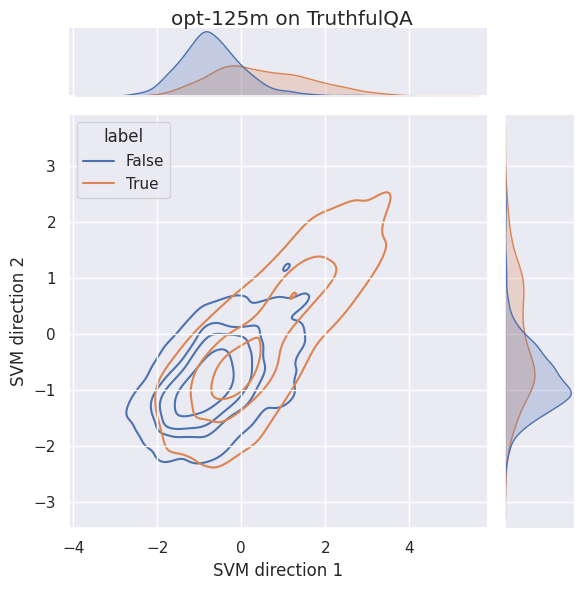

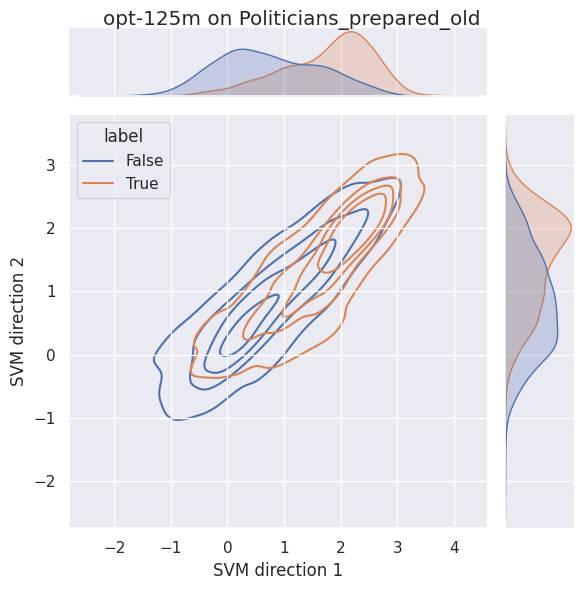

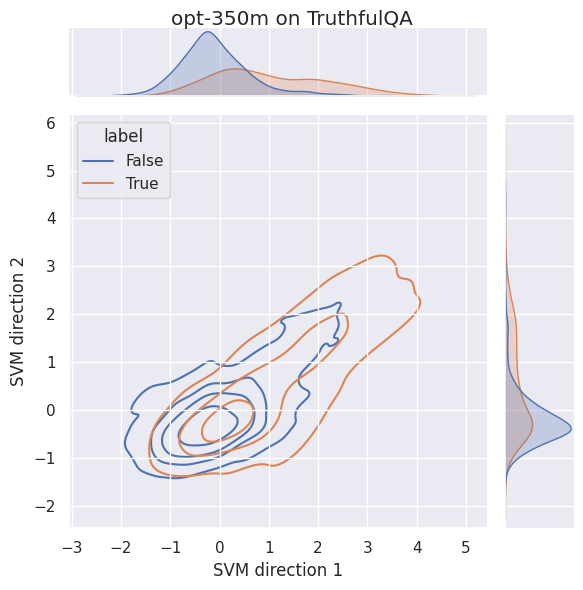

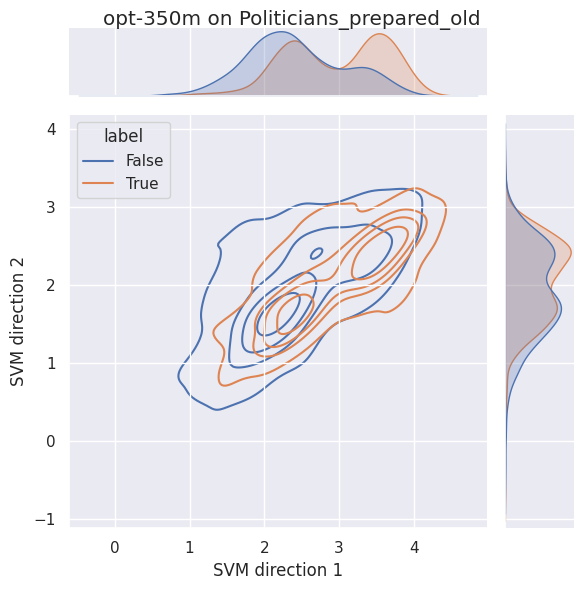

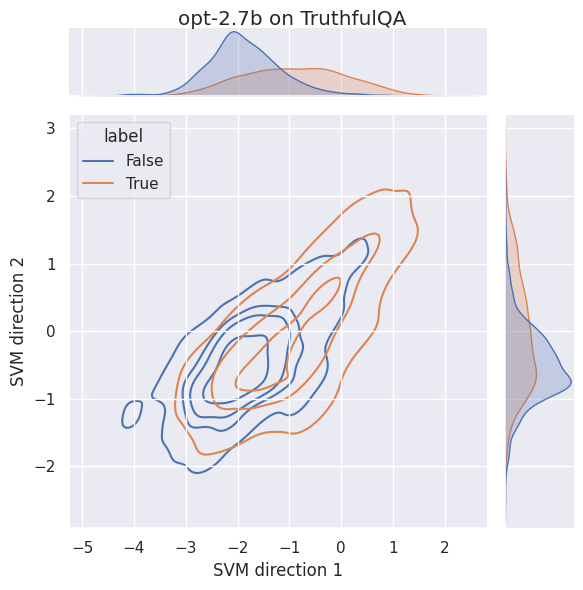

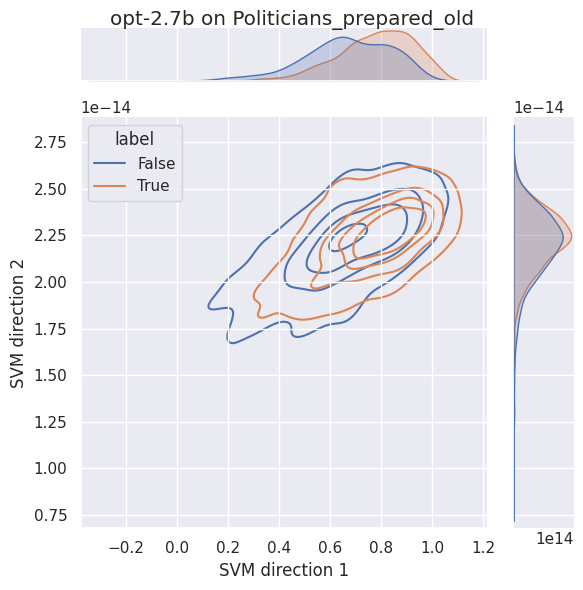

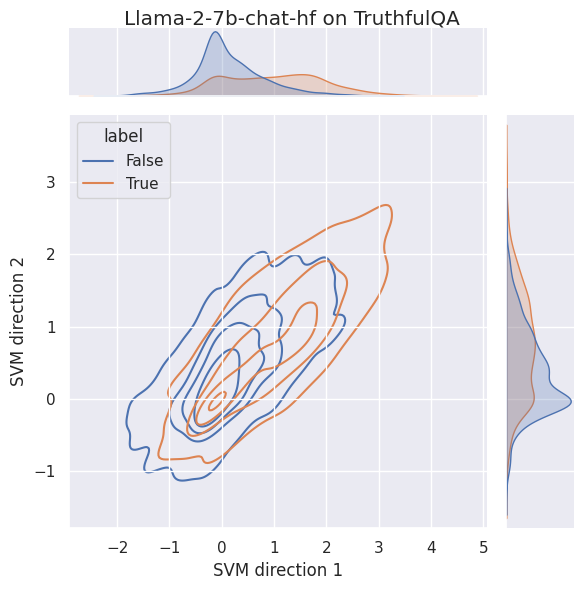

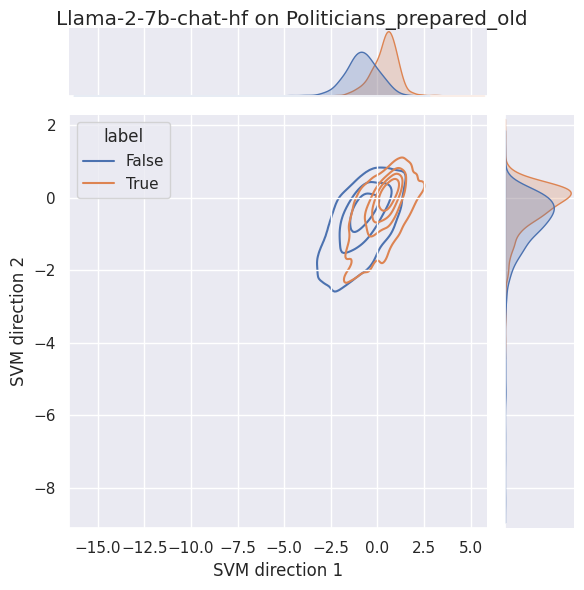

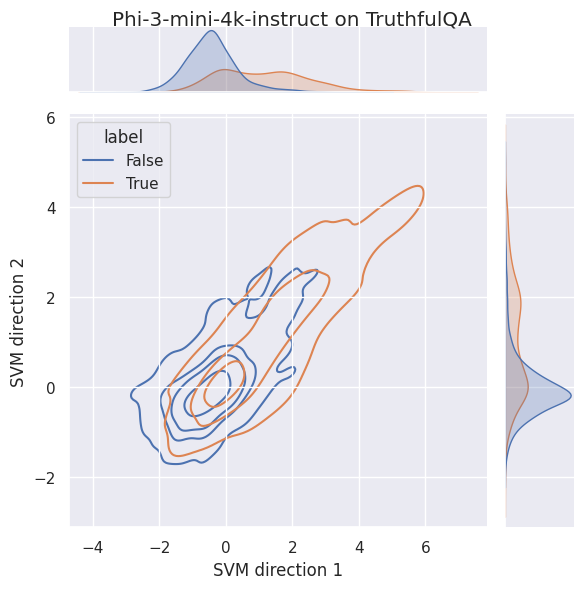

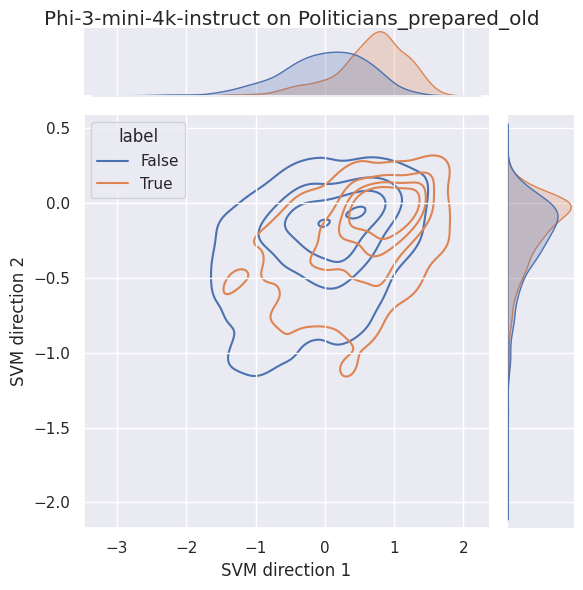

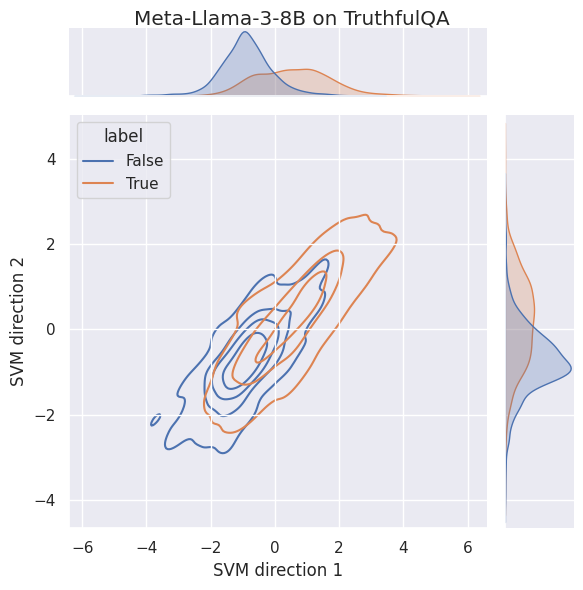

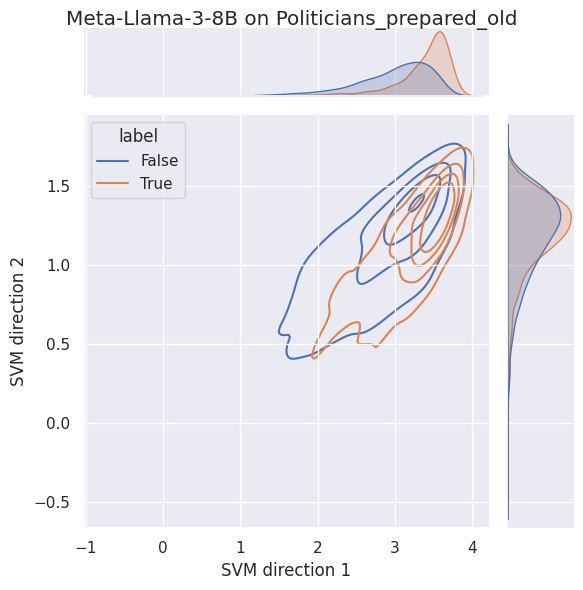

In [12]:
import pandas as pd
from IPython.display import display, clear_output

performance_df = pd.DataFrame(columns=datasets, index=[model.split('/')[-1] for model in models])
model_results_nonlinear_svm_without_ood = {}

for i, model in tqdm(enumerate(models), total=len(models), desc='Models', leave=False):
  row = []
  model_name_str = model.split('/')[-1]
  model_results_nonlinear_svm_without_ood[model_name_str] = {}
  for ds_name in tqdm(datasets, desc='Datasets', leave=False):
    ds_acts = np.load(os.path.join(data_dir, f"Activations_{ds_name}_{model_name_str}.npz"), allow_pickle=True)
    activations = ds_acts['activations']
    labels = ds_acts['labels']
    groups = ds_acts['group']
    results, study = CV_experiment(
        activations=activations,
        labels=labels,
        groups=groups,
        param_grid=rbf_svm_params,
        n_trials=1000,
        title=f"{model_name_str} on {ds_name}",
    )
    model_results_nonlinear_svm_without_ood[model_name_str][ds_name] = results
    row.append(results['test_acc_CI'])


  performance_df.loc[model_name_str] = row
  clear_output(wait=True)
  display(performance_df)
  print(f"Time for {model_name_str}: {results['CV_time']:.2f}s")

print(performance_df.to_latex())
performance_df

In [13]:
print(performance_df.to_latex())

\begin{tabular}{lll}
\toprule
 & TruthfulQA & Politicians_prepared_old \\
\midrule
opt-125m & ['76%', '80%'] & ['75%', '79%'] \\
opt-350m & ['74%', '78%'] & ['71%', '76%'] \\
opt-2.7b & ['73%', '77%'] & ['68%', '73%'] \\
Llama-2-7b-chat-hf & ['69%', '73%'] & ['76%', '81%'] \\
Phi-3-mini-4k-instruct & ['77%', '80%'] & ['74%', '79%'] \\
Meta-Llama-3-8B & ['77%', '81%'] & ['76%', '81%'] \\
\bottomrule
\end{tabular}



# Other confidence intervals
- For the first one with ood, I test this: OOD generalizability of the probes.
- Maybe I could also do TruthfulQA_probe > individual probe?
- For the one without ood, I test this: RBF > linear?

In [14]:
import numpy as np
from scipy.stats import beta

def bootstrap_CI(p, alpha=0.05, k=2000, n_decimals=0):
  """
    Computes the confidence interval of the mean using bootstrapping.
    Here the confidence interval is the 100*(1-alpha) central CI, from percentile 100*(alpha/2) to 100*(1-alpha/2) rounded to broadest interval when picking the indices.
    Line Clemmensen suggests picking k (number of repeats) to 1000 or 2000 for this tasks, so I do this.
  """
  assert isinstance(p, np.ndarray)
  assert p.ndim == 1
  N = len(p)
  bootstraps = np.random.choice(p, (k,N), replace=True)
  ci_lower = alpha/2.
  ci_upper = 1.-(alpha/2.)
  idxs = [
    int(np.floor(k*ci_lower)),
    int(np.ceil(k*ci_upper))
  ]
  CI = np.sort(np.mean(bootstraps, axis=-1))[idxs]     # Sorts lowest to highest
  assert CI[0] < CI[1]  # To be on the safe side...
  CI = [f"{(c*100):.{n_decimals}f}%" for c in CI]
  return CI, N    # Returns CI and support (N)


def jeffrey_CI(is_correct, alpha=0.05, n_decimals=0):
  N = len(is_correct)
  m = np.sum(is_correct) #y_test_hat == y_test)
  a = m+0.5
  b = N-m+0.5
  CI = np.array([beta.ppf(q=q, a=a, b=b) for q in [alpha/2., 1-alpha/2.]])
  CI = [f"{(c*100):.{n_decimals}f}%" for c in CI]
  return CI, m, N

## In-distribution (TruthfulQA) vs OOD (the rest)

In [15]:
aggregated_results = pd.DataFrame(columns=["TruthfulQA"]+datasets_+['OOD aggregated'])
row = {
    ds_name: jeffrey_CI(np.hstack([model_results_linear_svm_with_ood[model_name_str.split('/')[-1]][f'ood_test_{i}_is_correct'] for model_name_str in models]))[0]
    for i, ds_name in enumerate(datasets_)
}
row['TruthfulQA'] = jeffrey_CI(np.hstack([model_results_linear_svm_with_ood[model_name_str.split('/')[-1]]['test_is_correct'] for model_name_str in models]))[0]
row['OOD aggregated'] = jeffrey_CI(np.hstack([model_results_linear_svm_with_ood[model_name_str.split('/')[-1]][f'ood_test_{i}_is_correct'] for model_name_str in models for i, _ in enumerate(datasets_)]))[0]
aggregated_results.loc["LinearSVM (with OOD)"] = row

row = {
    ds_name: jeffrey_CI(np.hstack([model_results_nonlinear_svm_with_ood[model_name_str.split('/')[-1]][f'ood_test_{i}_is_correct'] for model_name_str in models]))[0]
    for i, ds_name in enumerate(datasets_)
}
row['TruthfulQA'] = jeffrey_CI(np.hstack([model_results_nonlinear_svm_with_ood[model_name_str.split('/')[-1]]['test_is_correct'] for model_name_str in models]))[0]
row['OOD aggregated'] = jeffrey_CI(np.hstack([model_results_nonlinear_svm_with_ood[model_name_str.split('/')[-1]][f'ood_test_{i}_is_correct'] for model_name_str in models for i, _ in enumerate(datasets_)]))[0]
aggregated_results.loc["NonlinearSVM (with OOD)"] = row

row = {
    ds_name: jeffrey_CI(np.hstack([model_results_linear_svm_without_ood[model_name_str.split('/')[-1]][ds_name][f'test_is_correct'] for model_name_str in models]))[0]
    for i, ds_name in enumerate(datasets)
}
aggregated_results.loc["LinearSVM (all in-distribution)"] = row

row = {
    ds_name: jeffrey_CI(np.hstack([model_results_nonlinear_svm_without_ood[model_name_str.split('/')[-1]][ds_name][f'test_is_correct'] for model_name_str in models]))[0]
    for i, ds_name in enumerate(datasets)
}
aggregated_results.loc["NonlinearSVM (all in-distribution)"] = row

print(aggregated_results.to_latex())
aggregated_results

\begin{tabular}{llll}
\toprule
 & TruthfulQA & Politicians_prepared_old & OOD aggregated \\
\midrule
LinearSVM (with OOD) & ['71%', '73%'] & ['47%', '49%'] & ['47%', '49%'] \\
NonlinearSVM (with OOD) & ['77%', '78%'] & ['47%', '49%'] & ['47%', '49%'] \\
LinearSVM (all in-distribution) & ['72%', '74%'] & ['73%', '75%'] & NaN \\
NonlinearSVM (all in-distribution) & ['76%', '77%'] & ['75%', '77%'] & NaN \\
\bottomrule
\end{tabular}



TruthfulQA Politicians_prepared_old  \
LinearSVM (with OOD)                [71%, 73%]               [47%, 49%]   
NonlinearSVM (with OOD)             [77%, 78%]               [47%, 49%]   
LinearSVM (all in-distribution)     [72%, 74%]               [73%, 75%]   
NonlinearSVM (all in-distribution)  [76%, 77%]               [75%, 77%]   

                                   OOD aggregated  
LinearSVM (with OOD)                   [47%, 49%]  
NonlinearSVM (with OOD)                [47%, 49%]  
LinearSVM (all in-distribution)               NaN  
NonlinearSVM (all in-distribution)            NaN

In [16]:
aggregated_difference = pd.DataFrame(columns=["TruthfulQA"]+datasets_+['aggregated'])
row = {
    ds_name: bootstrap_CI(
        np.hstack([model_results_nonlinear_svm_with_ood[model_name_str.split('/')[-1]][f'ood_test_{i}_is_correct'] for model_name_str in models]).astype(np.int32)
        -
        np.hstack([model_results_linear_svm_with_ood[model_name_str.split('/')[-1]][f'ood_test_{i}_is_correct'] for model_name_str in models]).astype(np.int32)
    )[0] for i, ds_name in enumerate(datasets_)}
row['TruthfulQA'] = bootstrap_CI(
    np.hstack([model_results_nonlinear_svm_with_ood[model_name_str.split('/')[-1]]['test_is_correct'] for model_name_str in models]).astype(np.int32)
    -
    np.hstack([model_results_linear_svm_with_ood[model_name_str.split('/')[-1]]['test_is_correct'] for model_name_str in models]).astype(np.int32)
)[0]
row['aggregated'] = bootstrap_CI(
    np.hstack([model_results_nonlinear_svm_with_ood[model_name_str.split('/')[-1]][f'ood_test_{i}_is_correct'] for model_name_str in models for i, ds_name in enumerate(datasets_)]).astype(np.int32)
    -
    np.hstack([model_results_linear_svm_with_ood[model_name_str.split('/')[-1]][f'ood_test_{i}_is_correct'] for model_name_str in models for i, ds_name in enumerate(datasets_)]).astype(np.int32),
    n_decimals=2
)[0]
aggregated_difference.loc["Nonlinear - linear (with OOD)"] = row

row = {
    ds_name: bootstrap_CI(
        np.hstack([model_results_nonlinear_svm_without_ood[model_name_str.split('/')[-1]][ds_name][f'test_is_correct'] for model_name_str in models]).astype(np.int32)
        -
        np.hstack([model_results_linear_svm_without_ood[model_name_str.split('/')[-1]][ds_name][f'test_is_correct'] for model_name_str in models]).astype(np.int32)
    )[0] for i, ds_name in enumerate(datasets)}
row['aggregated'] = bootstrap_CI(
    np.hstack([model_results_nonlinear_svm_without_ood[model_name_str.split('/')[-1]][ds_name][f'test_is_correct'] for model_name_str in models for i, ds_name in enumerate(datasets)]).astype(np.int32)
    -
    np.hstack([model_results_linear_svm_without_ood[model_name_str.split('/')[-1]][ds_name][f'test_is_correct'] for model_name_str in models for i, ds_name in enumerate(datasets)]).astype(np.int32),
    n_decimals=2
)[0]
aggregated_difference.loc["Nonlinear - linear (all in-distribution)"] = row

print(aggregated_difference.to_latex())
aggregated_difference  # Here the aggregation is done over OOD and all datasets, respectively

\begin{tabular}{llll}
\toprule
 & TruthfulQA & Politicians_prepared_old & aggregated \\
\midrule
Nonlinear - linear (with OOD) & ['5%', '7%'] & ['-1%', '1%'] & ['-1.00%', '1.35%'] \\
Nonlinear - linear (all in-distribution) & ['3%', '4%'] & ['1%', '3%'] & ['2.14%', '3.41%'] \\
\bottomrule
\end{tabular}



TruthfulQA Politicians_prepared_old  \
Nonlinear - linear (with OOD)              [5%, 7%]                [-1%, 1%]   
Nonlinear - linear (all in-distribution)   [3%, 4%]                 [1%, 3%]   

                                               aggregated  
Nonlinear - linear (with OOD)             [-1.00%, 1.35%]  
Nonlinear - linear (all in-distribution)   [2.14%, 3.41%]